# Train-test of single PINN poisson

In [1]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
from jaxopt import LBFGS

In [2]:
from utils import data_path 
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

In [3]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))

def boundary_loss_factory(index: int, target: float | Array)-> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = xpinn.PINNs[index].v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss


In [4]:
def interior_loss_factory(index: int, rhs: Array) -> LFunc:
            
    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) - rhs

    v_residual = jit(vmap(residual, (None, 0)))#vmap(residual, (None, 0))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

In [5]:
@jit
def u_star(x):
    return np.product(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

In [6]:
def eval(x):
    a = 0
    if 0.25<=x[0]<=0.75 and 0.25<=x[1]<=0.75:
        a=1
    return a

def f():
    points=xpinn.PINNs[0].interior
    f=onp.zeros_like(points)
    for i,point in enumerate(points):
        f[i] = eval(point)
    return np.array(f)

rhs = f()

In [7]:
p0 = xpinn.PINNs[0]

p0.boundary_loss = boundary_loss_factory(0, 0)


p0.interior_loss = interior_loss_factory(0, rhs)
p0.create_loss()

<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x11f804c20>>

In [8]:
shapes = [[2, 20, 20, 20, 20, 20, 20, 20, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    #optimizer = LBFGS()
    optimizer = optax.adam(learning_rate=0.0008)

    pinn.init_params(shape, optimizer)

/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [9]:
n_iter = 10000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 0.22367417812347412
10.00% iter = 1000 of 10000: Total loss = 0.1789141595363617
20.00% iter = 2000 of 10000: Total loss = 0.17890825867652893
30.00% iter = 3000 of 10000: Total loss = 0.17890742421150208
40.00% iter = 4000 of 10000: Total loss = 0.17890635132789612
50.00% iter = 5000 of 10000: Total loss = 0.17890572547912598
60.00% iter = 6000 of 10000: Total loss = 0.17890475690364838
70.00% iter = 7000 of 10000: Total loss = 0.1789039671421051
80.00% iter = 8000 of 10000: Total loss = 0.178903728723526
90.00% iter = 9000 of 10000: Total loss = 0.17890165746212006
100.00% iter = 10000 of 10000: Total loss = 0.17890042066574097


(1, 10000)
0.22367418
0.22367418


Text(0.5, 1.0, 'Loss per Pinn over 10000 epochs')

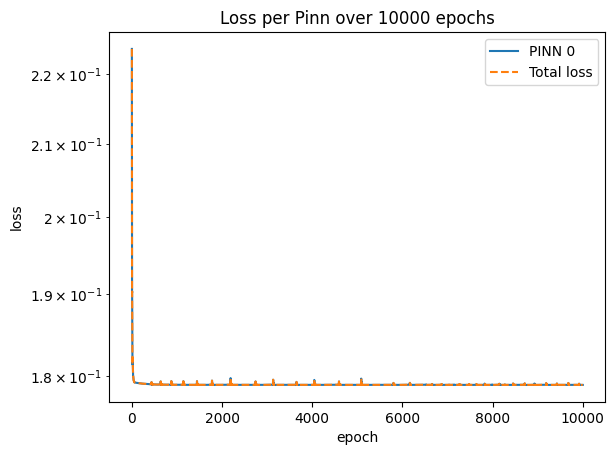

In [10]:
import matplotlib.pyplot as plt

a_losses = np.asarray(losses)
t_0 = 0
t = np.arange(t_0, n_iter)
print(a_losses.shape)
for i in range(2):
    print(a_losses[i,t_0])

for i in range(1):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

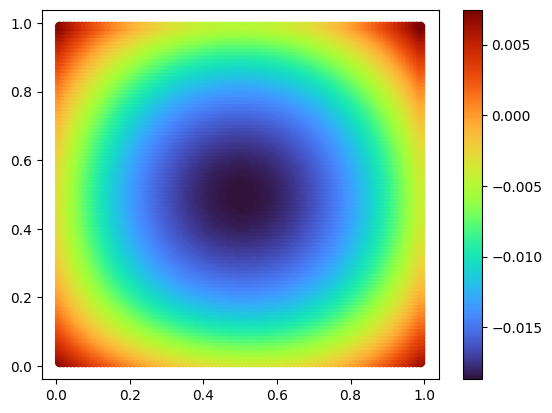

In [11]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()